# Data Cleaning + Organization

In [354]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

## NBA Player Salaries

Here we had two main goals:
1. Normalize player salaries - since the salary cap changes, we will look at how much a player earns per year as a proportion of the total salaries paid that year
2. Attach an age column. This is an instance where we are well served combining two smaller databases - the salaries database and the age database

In [2]:
salaries = pd.read_csv('data/nba_salaries.csv')
salaries.head()

,player,salary,season_end,season_start,team,team_name
0,Moses Malone,2406000,1991,1990,ATL,Atlanta Hawks
1,Dominique Wilkins,2065000,1991,1990,ATL,Atlanta Hawks
2,Jon Koncak,1550000,1991,1990,ATL,Atlanta Hawks
3,Doc Rivers,895000,1991,1990,ATL,Atlanta Hawks
4,Rumeal Robinson,800000,1991,1990,ATL,Atlanta Hawks


In [3]:
# Find total salaries paid in the NBA per year

yearly_totals = {}
for i in range(len(salaries)):
    year = salaries['season_end'][i]
    if year in yearly_totals.keys():
        yearly_totals[year] += salaries['salary'][i]
    else:
        yearly_totals[year] = salaries['salary'][i]

In [4]:
# Calculate each player's salary as a proportion of that year's total league-wide salaries.

salaries['salary'] = salaries['salary'].map(lambda s: float(s))
salaries['salary_proportion'] = 0.0

for i in range(len(salaries)):
    year = salaries['season_end'][i]
    salaries['salary_proportion'][i] = salaries['salary'][i] / yearly_totals[year]

In [5]:
# Scale the numbers - used 10,000 as a factor for interpretability (it keeps the values mostly between 0 and 100)

salaries['salary_scale'] = salaries['salary_proportion'].map(lambda s: s*10000)

salaries.head()

,player,salary,season_end,season_start,team,team_name,salary_proportion,salary_scale
0,Moses Malone,2406000.0,1991,1990,ATL,Atlanta Hawks,0.008196,81.958557
1,Dominique Wilkins,2065000.0,1991,1990,ATL,Atlanta Hawks,0.007034,70.342652
2,Jon Koncak,1550000.0,1991,1990,ATL,Atlanta Hawks,0.005280,52.799569
3,Doc Rivers,895000.0,1991,1990,ATL,Atlanta Hawks,0.003049,30.487493
4,Rumeal Robinson,800000.0,1991,1990,ATL,Atlanta Hawks,0.002725,27.251391


In [137]:
# Add player age in season to the dataframe

birthdate = pd.read_csv('data/player_info_2.csv')
birthdate_length = len(birthdate)

#Drop null values
birthdate = birthdate[birthdate['birth_date'].notnull()]

# Strip '*' from player names
birthdate['name'] = birthdate['name'].astype(str)
birthdate['name'] = birthdate['name'].map(lambda s: s.rstrip('*'))

# Pull year from birth_date
birthdate['birth_date'] = birthdate['birth_date'].map(lambda s: s[-4:])
birthdate['birth_date'] = pd.to_numeric(birthdate['birth_date'])

# Create dictionary of {player name: birth year}

birth_year = {}

for i in range(birthdate_length):
    if i in list(birthdate.index.values):
        player = birthdate['name'][i]
        year = birthdate['birth_date'][i]
        birth_year[birthdate['name'][i]] = year

In [138]:
# Calculate player's age each year in salaries table

salaries['age'] = 0.0
salaries['player'] = salaries['player'].map(lambda s: s.replace('\\', ""))

for i in range(len(salaries)):
    if salaries['player'][i] in birth_year.keys():
        salaries['age'][i] = salaries['season_start'][i] - birth_year[salaries['player'][i]]

salaries.head()

,player,salary,season_end,season_start,team,team_name,salary_proportion,salary_scale,age
0,Moses Malone,2406000.0,1991,1990,ATL,Atlanta Hawks,0.008196,81.958557,35.0
1,Dominique Wilkins,2065000.0,1991,1990,ATL,Atlanta Hawks,0.007034,70.342652,30.0
2,Jon Koncak,1550000.0,1991,1990,ATL,Atlanta Hawks,0.005280,52.799569,27.0
3,Doc Rivers,895000.0,1991,1990,ATL,Atlanta Hawks,0.003049,30.487493,29.0
4,Rumeal Robinson,800000.0,1991,1990,ATL,Atlanta Hawks,0.002725,27.251391,24.0


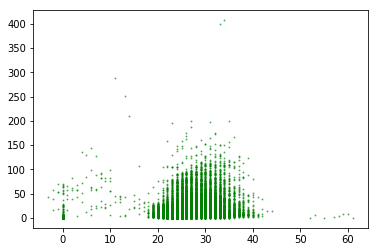

In [140]:
# Check for anomalies

x = salaries['age']
y = salaries['salary_scale']
plt.scatter(x, y, c="g", alpha=0.5, s=1)

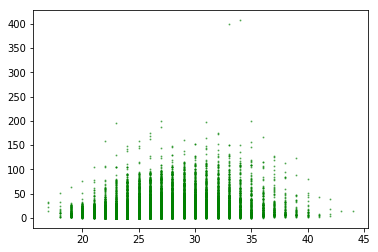

In [146]:
# Filter out missing, aberrant values (father/son, name issues)
# Normally, we'd prefer to address these individually. We have enough data that we can drop these in this case. 

salaries = salaries[salaries['age'] > 16]
salaries = salaries[salaries['age'] < 50]

x = salaries['age']
y = salaries['salary_scale']
plt.scatter(x, y, c="g", alpha=0.5, s=1)

In [144]:
# Write to CSV
salaries.to_csv('clean_salaries.csv')

## Combine Stats

The main issue here is that we have a lot of values. We have some decisions to make:
1. How to denote that a player is undrafted? Add a column? Add a placeholder value (99) for draft position?
2. How to fill missing values of certain measurements? Since a lot of these features are correlated, we shouldn't use mean or median (i.e. - a Center prospect should have different sized hands than a Guard). We will try to run some simple regressions to be able to fill data.

In [355]:
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

In [211]:
# Import dataset

combine = pd.read_csv('data/draft_combine_stats.csv')
combine.head()

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


In [212]:
# Identify missing values

combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 19 columns):
Unnamed: 0                  517 non-null int64
Player                      517 non-null object
Year                        517 non-null int64
Draft pick                  384 non-null float64
Height (No Shoes)           517 non-null float64
Height (With Shoes)         516 non-null float64
Wingspan                    517 non-null float64
Standing reach              517 non-null float64
Vertical (Max)              450 non-null float64
Vertical (Max Reach)        450 non-null float64
Vertical (No Step)          450 non-null float64
Vertical (No Step Reach)    450 non-null float64
Weight                      516 non-null float64
Body Fat                    514 non-null float64
Hand (Length)               470 non-null float64
Hand (Width)                468 non-null float64
Bench                       284 non-null float64
Agility                     444 non-null float64
Sprint            

We observe a lot of missing values in Draft Pick (for those undrafted) and some measurements (including Bench). 

We can probably infer that Bench is not meaningful (since it is more rarely measured). We'll still see what we can do with it.

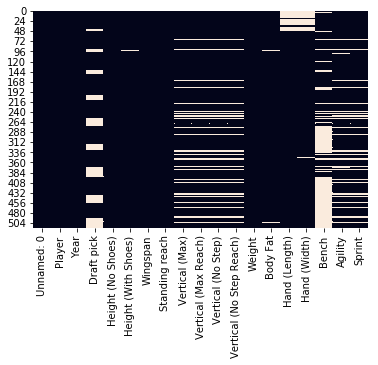

In [213]:
# Plot missing values. Where are patterns?

sns.heatmap(combine.isnull(), cbar=False)

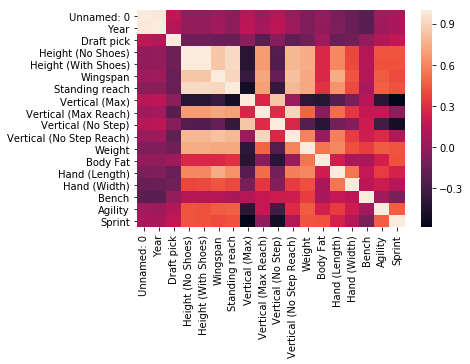

In [214]:
# Plot feature correlation

sns.heatmap(combine.corr())

In [215]:
# Precise feature correlation

# combine.corr()

1. Draft Pick - Add a column to denote undrafted, fill with a placeholder value
2. Height (With Shoes) - One measurement? We can find avg difference and use
3. Body Fat - Use median
4. Hand Size - Regress hand length on wingspan, hand widtg on hand length
5. Bench - Will just drop.
6. Vertical - This may be the trickiest to meaningfully measure. We'll try regression
7. Agility + Sprint - This may be tricky as well

#### 1. Draft Pick

In [216]:
# Add a dummy column to denote undrafted
combine['drafted'] = combine['Draft pick'].notnull().astype(int)

# Replace 'Draft pick' NaN with placeholder number (99.0)
combine['Draft pick'] = combine['Draft pick'].fillna(99.0)

#### 2. Height (with shoes)

In [217]:
# Filter missing values
shoes = combine[combine['Height (With Shoes)'].notnull()]
avg_diff = round(np.average(shoes['Height (With Shoes)'] - shoes['Height (No Shoes)']),2)

# Find players with missing value
no_shoes  = combine[combine['Height (With Shoes)'].isnull()]
# no_shoes - index 95 - Mikhail Torrance

# Replace value
combine['Height (With Shoes)'][95] = combine['Height (No Shoes)'][95] + avg_diff
# combine[94:100]

#### 3. Body Fat

In [218]:
# Filter out NaN, find median
bf = combine[combine['Body Fat'].notnull()]
med_bf = round(np.median(bf['Body Fat']),2)

# Fill NaN with median
combine['Body Fat'] = combine['Body Fat'].fillna(med_bf)

#### 4. Hand Length + Width

In [219]:
# First, we'll regress Hand Length on Wingspan

df_length = combine[combine['Hand (Length)'].notnull()]

x_length = df_length['Wingspan'].values.reshape(-1, 1)
y_length = df_length['Hand (Length)']

clf_length = linear_model.LinearRegression()
clf_length.fit(x_length, y_length)

# print intercept and coefficients
print('Intercept: ', clf_length.intercept_)
print('Coef: ', clf_length.coef_)

# Print regression equation

'Hand Length = %f + %f * Wingspan'%(clf_length.intercept_, clf_length.coef_)

('Intercept: ', 1.266946280094519)
('Coef: ', array([0.09027844]))


'Hand Length = 1.266946 + 0.090278 * Wingspan'

In [220]:
# Next, we'll regress Hand Width on Hand Length

df_width = df_length[df_length['Hand (Width)'].notnull()]
x_width = df_width['Hand (Length)'].values.reshape(-1, 1)
y_width = df_width['Hand (Width)']

clf_width = linear_model.LinearRegression()
clf_width.fit(x_width, y_width)

# print intercept and coefficients
print('Intercept: ', clf_width.intercept_)
print('Coef: ', clf_width.coef_)

# Print regression equation

'Hand Width = %f + %f * Hand Length'%(clf_width.intercept_, clf_width.coef_)

('Intercept: ', 2.030587208934098)
('Coef: ', array([0.84457252]))


'Hand Width = 2.030587 + 0.844573 * Hand Length'

In [221]:
# Calculate values for hand length and width
combine['Hand (Length)'] = combine['Hand (Length)'].fillna(0.0)
combine['Hand (Width)'] = combine['Hand (Width)'].fillna(0.0)

for i in range(len(combine)):
    if combine['Hand (Length)'][i] == 0.0:
        combine['Hand (Length)'][i] = round((1.266946 + 0.090278 * combine['Wingspan'][i]),2)
        
for i in range(len(combine)):
    if combine['Hand (Width)'][i] == 0.0:
        combine['Hand (Width)'][i] = round((2.030587 + 0.844573 * combine['Hand (Length)'][i]),2)

#### 5. Bench

In [222]:
# Too many missing values for a heuristically meaningless variable. Will drop

combine = combine.drop(['Bench'], axis = 1)

#### 6 + 7 - Athleticism measurements

Roughly 13% of the participants are missing all of the athletic measurements (67 of the 517). 78 are missing at least two.

Since we don't want to lose those players' info completely, and we can't fill those in meaningfully, we can split this dataset into two:
1. combine_physical - Has only the physical measurements (size, weight, etc.) for all players but no athletic measurements
2. combine_athletic - Has all features, but only for the players who participated in all athletic measurement tests

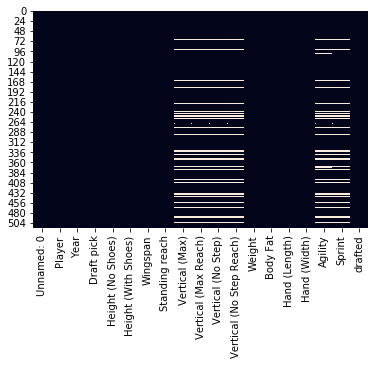

In [223]:
# Check our missing values

sns.heatmap(combine.isnull(), cbar=False)

In [224]:
# First, we'll drop athletic measurement rows to create combine_physical

combine_physical = combine.drop(['Vertical (Max)','Vertical (Max Reach)', 'Vertical (No Step)', 'Vertical (No Step Reach)', 'Agility', 'Sprint'],axis=1)

In [225]:
# Next, we'll filter out players with missing athletic values to create the combine_athletic dataframe

df_vm = combine[combine['Vertical (Max Reach)'].notnull()]
df_vn = df_vm[df_vm['Vertical (No Step)'].notnull()]
df_ag = df_vn[df_vn['Agility'].notnull()]
combine_athletic = df_ag[df_ag['Sprint'].notnull()]

In [226]:
# Add a dummy column to the combine_physical dataframe to indicate if a player participated in athletic testing

athletic_list = combine_athletic['Player'].tolist()

combine_physical['athletic'] = combine_physical['Player'].map(lambda s: s in athletic_list).astype(int)

combine_physical


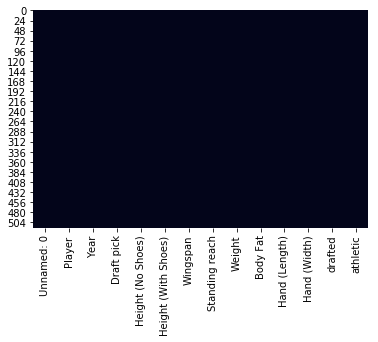

In [227]:
# Double check for missing values in each
print "combine_physical"
sns.heatmap(combine_physical.isnull(), cbar=False)

combine_athletic


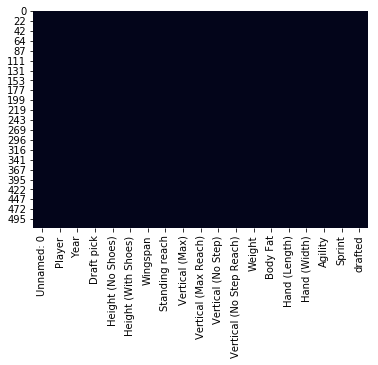

In [228]:
# Double check for missing values in each
print "combine_athletic"
sns.heatmap(combine_athletic.isnull(), cbar=False)

In [229]:
# Export clean table to csv
combine_physical.to_csv('combine_physical.csv')
combine_athletic.to_csv('combine_athletic.csv')

## NBA Stats - Drafted Players

This is data we can probably scrounge together from other dataframes we have, but it will be nice to have it in one purposeful, organized dataframe such as this.

In [232]:
draft_nba = pd.read_csv('data/draft_nba_stats.csv')
draft_nba.head()

,Unnamed: 0,Draft_Yr,Pk,Tm,Player,College,Yrs,G,MP,PTS,...,3P_Perc,FT_Perc,MP.1,PTS_per_G,TRB_per_G,AST_per_G,WS_per_G,WS_per_48,BPM,VORP
0,0,2009,1,LAC,Blake Griffin,University of Oklahoma,9,546,19154,11780,...,0.333,0.685,19154,21.6,9.2,4.3,69.1,0.173,4.0,28.9
1,1,2009,2,MEM,Hasheem Thabeet,University of Connecticut,5,224,2357,483,...,0.000,0.578,2357,2.2,2.7,0.1,4.8,0.099,-1.4,0.4
2,2,2009,3,OKC,James Harden,Arizona State University,10,703,23837,16313,...,0.364,0.853,23837,23.2,5.1,6.1,108.8,0.219,6.6,51.4
3,3,2009,4,SAC,Tyreke Evans,University of Memphis,10,544,17237,8845,...,0.321,0.759,17237,16.3,4.7,5.0,28.4,0.079,1.0,13.2
4,4,2009,5,MIN,Ricky Rubio,NaN,8,451,14087,4924,...,0.325,0.835,14087,10.9,4.3,7.8,29.0,0.099,1.2,11.5


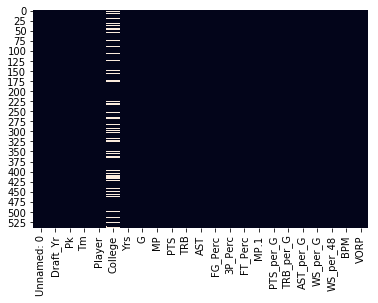

In [233]:
sns.heatmap(draft_nba.isnull(), cbar=False)

All we are really missing here is the college which essentially indicates that a player is international. A simple fix.

In [235]:
# Fill NA values with 'International' designation

draft_nba['College'] = draft_nba['College'].fillna('International')

In [236]:
# Export clean table to csv
draft_nba.to_csv('clean_draft_nba.csv')

## NCAA Stats - Drafted Players

This is a comprehensive dataframe. We'll try to clean it up and break it into a couple separate dataframes depending on need:
1. Yearly - shows their stats each year
2. Total - shows their average / total stats over their careers
3. Last - shows their stats in the season before they were drafted

In [301]:
draft_ncaa = pd.read_csv('data/draft_ncaa_stats.csv')
draft_ncaa.head()

,Unnamed: 0,2P,2P%,2PA,3P,3P%,3PA,AST,Awards,BLK,...,ORB,PF,PTS,SOS,STL,School,Season,TOV,TRB,
0,0,5.6,0.571,9.8,0.0,0.000,0.1,1.8,NaN,0.8,...,3.3,2.5,14.7,7.85,1.0,Oklahoma,['2007-08'],2.3,9.1,0.0
1,1,8.5,0.659,12.9,0.1,0.375,0.2,2.3,AP POY; NABC POY; TSN POY ...,1.2,...,3.9,2.5,22.7,6.88,1.1,Oklahoma,['2008-09'],3.3,14.4,0.0
2,2,7.1,0.622,11.4,0.0,0.300,0.1,2.1,NaN,1.0,...,3.6,2.5,18.8,7.37,1.1,Oklahoma,['Career'],2.8,11.8,0.0
3,3,2.2,0.554,3.9,0.0,0.000,0.0,0.4,NaN,3.8,...,2.4,2.6,6.2,6.08,0.2,UConn,['2006-07'],1.6,6.4,0.0
4,4,3.5,0.603,5.7,0.0,0.000,0.0,0.4,NaN,4.5,...,2.9,2.6,10.5,6.75,0.3,UConn,['2007-08'],1.8,7.9,0.0


In [310]:
# First, let's rearrange the columns into something more intuitive

cols = list(draft_ncaa.columns.values)
cols_new = ['Name', 'School', 'Conf','Season', 'SOS', 'G', 'GS', 'MP', 'PTS', 'DRB', 'ORB', 'TRB', 
            'AST', 'STL', 'BLK', 'TOV', 'PF', 'FG', 'FGA', 'FG%', 'FT', 'FTA', 'FT%', '2P', '2PA', '2P%', 
            '3P', '3PA', '3P%']

draft_ncaa = draft_ncaa[cols_new]
draft_ncaa.head()

,Name,School,Conf,Season,SOS,G,GS,MP,PTS,DRB,...,FG%,FT,FTA,FT%,2P,2PA,2P%,3P,3PA,3P%
0,Blake Griffin,Oklahoma,Big 12,2007-08,7.85,33,28,28.4,14.7,5.8,...,0.568,3.5,6.0,0.589,5.6,9.8,0.571,0.0,0.1,0.000
1,Blake Griffin,Oklahoma,Big 12,2008-09,6.88,35,35,33.3,22.7,10.5,...,0.654,5.5,9.3,0.590,8.5,12.9,0.659,0.1,0.2,0.375
2,Blake Griffin,Oklahoma,Big 12,Career,7.37,68,63,30.9,18.8,8.3,...,0.618,4.5,7.7,0.589,7.1,11.4,0.622,0.0,0.1,0.300
3,Hasheem Thabeet,UConn,Big East,2006-07,6.08,31,31,24.6,6.2,4.0,...,0.554,1.9,3.7,0.513,2.2,3.9,0.554,0.0,0.0,0.000
4,Hasheem Thabeet,UConn,Big East,2007-08,6.75,33,32,31.0,10.5,4.9,...,0.603,3.6,5.1,0.698,3.5,5.7,0.603,0.0,0.0,0.000


['Unnamed: 0',
 '2P',
 '2P%',
 '2PA',
 '3P',
 '3P%',
 '3PA',
 'AST',
 'Awards',
 'BLK',
 'Conf',
 'DRB',
 'FG',
 'FG%',
 'FGA',
 'FT',
 'FT%',
 'FTA',
 'G',
 'GS',
 'MP',
 'Name',
 'ORB',
 'PF',
 'PTS',
 'SOS',
 'STL',
 'School',
 'Season',
 'TOV',
 'TRB',
 '\xc2\xa0']

In [304]:
# Reformat 'Season' column

draft_ncaa['Season'] = draft_ncaa['Season'].map(lambda s: s.lstrip('[\'').rstrip('\']'))

In [305]:
# Add column for EFG% (Effective Field Goal %) - a better summary of a player's scoring efficiency
#  (FG + 0.5 * 3P) / FGA.

draft_ncaa['EFG%'] = (draft_ncaa['FG'] + 0.5 * draft_ncaa['3P']) / draft_ncaa['FGA']

In [311]:
# Add conference to the 'Career' rows

# Create dictionary with {school: conference} pairs
conferences = {}
for i in range(len(draft_ncaa)):
    if draft_ncaa['School'][i] not in conferences.keys():
        conferences[draft_ncaa['School'][i]] = draft_ncaa['Conf'][i]

# Replace 'Conf' column with these values

for i in range(len(draft_ncaa)):
    draft_ncaa['Conf'][i] = conferences[draft_ncaa['School'][i]]

In [322]:
# Add year designation to dataframe (will drop later for 'total' dataframe)

draft_ncaa['year'] = 0

prev_player = ''
year = 1

for i in range(len(draft_ncaa)):
    if prev_player != draft_ncaa['Name'][i]:
        year = 1
        draft_ncaa['year'][i] = year
        prev_player = draft_ncaa['Name'][i]
    else:
        year += 1
        draft_ncaa['year'][i] = year

In [341]:
# Split into yearly / total dataframes

draft_ncaa_yearly = draft_ncaa[draft_ncaa['Season'] != 'Career']
draft_ncaa_total = draft_ncaa[draft_ncaa['Season'] == 'Career']

draft_ncaa_yearly = draft_ncaa_yearly.reset_index()

In [342]:
# Drop 'year' column from total dataframe

draft_ncaa_total = draft_ncaa_total.drop(['year'], axis = 1)

In [344]:
# Find last season before draft stats

draft_ncaa_yearly['last'] = 0

# Create dictionary of player's last year

last = {}

for i in range(len(draft_ncaa_yearly)):
    last[draft_ncaa_yearly['Name'][i]] = draft_ncaa_yearly['year'][i]
    
# Set 'last' designation

for i in range(len(draft_ncaa_yearly)):
    if last[draft_ncaa_yearly['Name'][i]] == draft_ncaa_yearly['year'][i]:
        draft_ncaa_yearly['last'][i] = 1

In [346]:
# Create a 'last year' dataframe

draft_ncaa_last = draft_ncaa_yearly[draft_ncaa_yearly['last'] == 1]
draft_ncaa_last = draft_ncaa_last.reset_index()

In [349]:
# Change formatting of 'Season' in applicable dataframes

draft_ncaa_yearly['Season'] = draft_ncaa_yearly['Season'].map(lambda s: "20"+s[-2:])
draft_ncaa_last['Season'] = draft_ncaa_last['Season'].map(lambda s: "20"+s[-2:])

In [353]:
# Export clean tables to csv
draft_ncaa_yearly.to_csv('clean_draft_ncaa_yearly.csv')
draft_ncaa_last.to_csv('clean_draft_ncaa_last.csv')
draft_ncaa_total.to_csv('clean_draft_ncaa_total.csv')

## NBA Stats - Season over season

This is NBA stats for every player in every season. We'll simply drop na's since this is so robust.

In [370]:
nba = pd.read_csv('data/player_stats_with_age.csv')

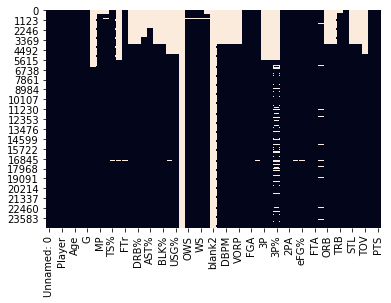

In [371]:
sns.heatmap(nba.isnull(), cbar=False)

In [372]:
len(nba)

24691

In [373]:
# Drop columns that are all NA
nba = nba.dropna(axis = 1, how = 'all')

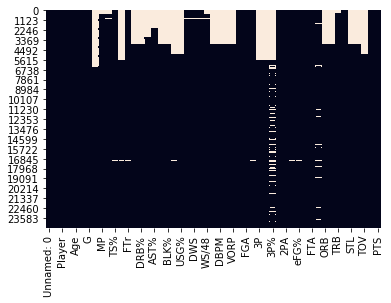

In [374]:
sns.heatmap(nba.isnull(), cbar=False)

In [375]:
# Drop rows that contain any NA
nba = nba.dropna(how = 'any')

14585


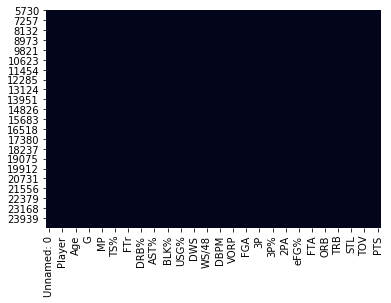

In [376]:
print len(nba)
sns.heatmap(nba.isnull(), cbar=False)

In [378]:
# Strip '*' from player names
nba['Player'] = nba['Player'].astype(str)
nba['Player'] = nba['Player'].map(lambda s: s.rstrip('*'))

In [379]:
nba

,Unnamed: 0,Year_end,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5730,5730,1980.0,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,15.3,...,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
5748,5748,1980.0,Larry Bird,PF,23.0,BOS,82.0,82.0,2955.0,20.5,...,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0
5781,5781,1980.0,M.L. Carr,SF,29.0,BOS,82.0,7.0,1994.0,14.6,...,0.739,106.0,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0
5786,5786,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,7.8,...,0.762,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0
5802,5802,1980.0,Dave Cowens,C,31.0,BOS,66.0,55.0,2159.0,14.8,...,0.779,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0
5835,5835,1980.0,Chris Ford,SG,31.0,BOS,73.0,73.0,2115.0,13.0,...,0.754,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0
5867,5867,1980.0,Gerald Henderson,PG,24.0,BOS,76.0,2.0,1061.0,12.7,...,0.690,37.0,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0
5901,5901,1980.0,Jeff Judkins,SF,23.0,BOS,65.0,0.0,674.0,14.1,...,0.816,32.0,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0
5947,5947,1980.0,Pete Maravich,SG,32.0,TOT,43.0,4.0,964.0,13.8,...,0.867,17.0,61.0,78.0,83.0,24.0,6.0,82.0,79.0,589.0
5949,5949,1980.0,Pete Maravich,SG,32.0,BOS,26.0,4.0,442.0,15.6,...,0.909,10.0,28.0,38.0,29.0,9.0,2.0,37.0,49.0,299.0


In [380]:
# Export to csv
nba.to_csv('clean_nba_history.csv')